In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from cross_Transformer_nys import Trans_C as Trans_C_nys
from cross_Transformer import Trans_C
from loss.dilate_loss import DilateLoss
import math
import random
import os
# Set random seed

def seed_torch(seed=2025):
    random.seed(seed)  
    os.environ['PYTHONHASHSEED'] = str(seed)   
    np.random.seed(seed)  
    torch.manual_seed(seed)   
    torch.cuda.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False   
    torch.backends.cudnn.deterministic = True  

seed_torch()
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}.")
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
from sklearn.preprocessing import StandardScaler
from RevIN import RevIN
rcParams['figure.figsize'] = 13, 4

# Box
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['navy','goldenrod'])

# Grid and axis thickness, color
rcParams['axes.linewidth'] = 1
rcParams['axes.edgecolor'] = '#5B5859'
rcParams['axes.ymargin'] = 0
rcParams['axes.grid'] = True
rcParams['axes.grid.axis'] = 'y'
rcParams['axes.axisbelow'] = True
rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.5

# xticks, yticks
rcParams['ytick.major.width'] = 0
rcParams['ytick.major.size'] = 0
rcParams['ytick.color'] = '#393433'
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.size'] = 3
rcParams['xtick.color'] = '#393433'

# Line thickness
rcParams['lines.linewidth'] = 1.5

# Saving quality
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 500
rcParams['savefig.transparent'] = True

Using cuda.


In [2]:
site=708
csv_path = Path(f"E:\Project2024\canada\DATA1\WTS{site}_1.csv")
df = pd.read_csv(csv_path)

In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# Day in a month
df["Day_of_month"] = df.Date.apply(lambda x: x.day)
# Day in a week
df["Day_of_week"] = df.Date.apply(lambda x: x.dayofweek)
# 24-hour based
df["Hour"] = df.Date.apply(lambda x: x.hour)
# Week in a year
df["Week"] = df.Date.apply(lambda x: x.week)
# Set "DateTime" column as row index
df = df.set_index("Date")
df.head()

,Qrate,Rain,Day_of_month,Day_of_week,Hour,Week
Date,,,,,,
2014-09-09 12:00:00,0.0186,0.0,9,1,12,37
2014-09-09 13:00:00,0.0188,0.0,9,1,13,37
2014-09-09 14:00:00,0.0188,0.0,9,1,14,37
2014-09-09 15:00:00,0.0185,0.0,9,1,15,37
2014-09-09 16:00:00,0.0185,0.0,9,1,16,37


In [4]:

batch_size = 32
in_seq_len=past_len=24# How far to look back
out_seq_len=pred_len =24# How far to look forward
forecast_length = out_seq_len# Hours ahead to predict
enc_in_size = df.shape[1] # Number of input features + target feature
dec_in_size = 6 # Number of known future features + target feature
output_size = 1 # Number of target features
hidden_size = 128 # Dimensions in hidden layers
num_layers = 2# Number of hidden layers
patch_len=6
num_epochs = 300
learning_rate = 1e-3
es_patience = 20
lr_patience = 10
model_save_path = "checkpoint_seq2seq.pth"
df['Qrate'] = np.log1p(df['Qrate'])
df['Rain'] = np.log1p(df['Rain'])

scaler_qrate = StandardScaler()
scaler_rain = StandardScaler()
df['Qrate'] = scaler_qrate.fit_transform(df[['Qrate']])
df['Rain'] = scaler_rain.fit_transform(df[['Rain']])

# Move target to the last column
target_feature = "Qrate"
df.insert(len(df.columns)-1, target_feature, df.pop(target_feature))
data = df.values

testNum = validationNum = 8750
total_rows = len(df)
assert total_rows == testNum * 2 + (train_df_rows := total_rows - 2*testNum), "数据行数不支持这样的划分"
data_train = df[:train_df_rows].copy()
data_val = df[train_df_rows:train_df_rows+validationNum].copy()
data_test = df[train_df_rows+validationNum:train_df_rows+validationNum+testNum].copy()
print("Training Shape:", data_train.shape)
print("Validation Shape:", data_val.shape)
print("Testing Shape:", data_test.shape)

Training Shape: (26627, 6)
Validation Shape: (8750, 6)
Testing Shape: (8750, 6)


In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, past_len=past_len, pred_len=pred_len):
        # Create data sequences
        data_len = data.shape[0]
        # 27725
        X, Y = list(), list()

        for i in range(data_len):
            input_end = i + past_len

            output_end = input_end + pred_len

            # check if we are beyond the dataset
            if output_end > data_len:
                break
            else:
                X.append(data[i:input_end])
                Y.append(data.iloc[input_end:output_end, -1].values)

        # Shape (samples, seq_len, features)
        self.X = np.array(X)
        # Shape (samples, seq_len, ) : univariate
        self.Y = np.array(Y)

    def __len__(self):
        # return the size of the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # return one sample from the dataset
        features = self.X[idx]
        target = self.Y[idx]
        return features, target
train_dataset = TimeSeriesDataset(data_train)
val_dataset = TimeSeriesDataset(data_val)
test_dataset = TimeSeriesDataset(data_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
X, y = next(iter(train_loader))

print("Features shape:", X.size())
print("Target shape:", y.size())

Features shape: torch.Size([32, 24, 6])
Target shape: torch.Size([32, 24])


In [6]:
class Filter(nn.Module):
    def __init__(self, channel=1, kernel_size=12):
        super(Filter, self).__init__()
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(channel, channel, kernel_size=kernel_size, stride=1,
                              padding=int(kernel_size // 2), padding_mode='replicate', bias=True, groups=channel)
        self.conv.weight = nn.Parameter(
            (1 / kernel_size) * torch.ones([channel, 1, kernel_size]))

    def forward(self, inp):
        out = self.conv(inp.transpose(1, 2)).transpose(1, 2)
        return out


class Fredformer_backbone(nn.Module):
    def __init__(self, context_window: int, target_window: int, ablation: int, mlp_drop: float, use_nys: int, output: int, mlp_hidden: int, cf_dim: int,
                 cf_depth: int, cf_heads: int, cf_mlp: int, cf_head_dim: int, cf_drop: float, c_in: int,
                 patch_len: int, stride: int, d_model: int,
                 head_dropout=0, padding_patch=None, individual=False, revin=False, affine=True, subtract_last=False,
                 **kwargs):

        super().__init__()
        self.use_nys = use_nys
        self.ablation = ablation
        self.beta=0.2
        # RevIn

        self.output = output
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        self.targetwindow = target_window
        self.horizon = self.targetwindow
        patch_num = int((context_window - patch_len) / stride + 1)
        self.norm = nn.LayerNorm(patch_len)
        self.Filter = Filter(c_in, kernel_size=25)
        # print("depth=",cf_depth)
        # Backbone
        self.re_attn = True
        if self.use_nys == 0:
            self.fre_transformer = Trans_C(dim=cf_dim, depth=cf_depth, heads=cf_heads, mlp_dim=cf_mlp,
                                           dim_head=cf_head_dim, dropout=cf_drop, patch_dim=patch_len * 2,
                                           horizon=self.horizon * 2, d_model=d_model * 2)
        else:
            self.fre_transformer = Trans_C_nys(dim=cf_dim, depth=cf_depth, heads=cf_heads, mlp_dim=cf_mlp,
                                               dim_head=cf_head_dim, dropout=cf_drop, patch_dim=patch_len * 2,
                                               horizon=self.horizon * 2, d_model=d_model * 2)

        # Head
        self.head_nf_f = d_model * 2 * patch_num  # self.horizon * patch_num#patch_len * patch_num#1408
        self.n_vars = c_in
        self.individual = individual
        self.head_f1 = Flatten_Head(self.individual, self.n_vars, self.head_nf_f, target_window,
                                    head_dropout=head_dropout)
        self.head_f2 = Flatten_Head(self.individual, self.n_vars, self.head_nf_f, target_window,
                                    head_dropout=head_dropout)

        self.ircom = nn.Linear(self.targetwindow * 2, self.targetwindow)
        self.rfftlayer = nn.Linear(self.targetwindow * 2 - 2, self.targetwindow)
        self.final = nn.Linear(self.targetwindow * 2, self.targetwindow)
        self.inn = INN_all(num_layers=1)
        self.Linear1=nn.Linear(c_in, d_model*2)
        self.adaptive= nn.Parameter(torch.ones(2))


        # break up R&I:
        self.get_r = nn.Linear(d_model * 2, d_model * 2)
        self.get_i = nn.Linear(d_model * 2, d_model * 2)
        self.output1 = nn.Linear(target_window, target_window)

        # ablation
        self.input = nn.Linear(c_in, patch_len * 2)
        self.outpt = nn.Linear(d_model * 2, c_in)
        self.abfinal = nn.Linear(patch_len * patch_num, target_window)
        self.fc=nn.Linear(6,1)
        self.flatten = nn.Flatten(start_dim=-2)
        self.CIAA=CIAA(d_model, n_heads=8, use_cls=True)

    def fftpatch(self,tensor, patch_len, stride):

        fft_result = torch.fft.fft(tensor)

        real_part = fft_result.real
        imag_part = fft_result.imag

        real_unfolded = real_part.unfold(dimension=-1, size=patch_len,
                                         step=stride)  # [bs x nvars x patch_num x patch_len]
        imag_unfolded = imag_part.unfold(dimension=-1, size=patch_len,
                                         step=stride)  # [bs x nvars x patch_num x patch_len]

        return real_unfolded, imag_unfolded
    def forward(self,z):
        x = z - self.beta * self.Filter(z)
        x1, x2 = self.fftpatch(x.permute(0, 2, 1), self.patch_len, self.stride)#32,6,4,6


        z = z.permute(0, 2, 1)  # [bs x seq_len x nvars] -> [bs x nvars x seq_len]
        z1, z2 = self.fftpatch(z, self.patch_len, self.stride)
        #z1 = z1.unfold(dimension=-1, size=self.patch_len, step=self.stride)  # z1: [bs x nvars x patch_num x patch_len]
        #z2 = z2.unfold(dimension=-1, size=self.patch_len,step=self.stride)  # z2: [bs x nvars x patch_num x patch_len]32,6,4,6

        # for channel-wise_1
        z1 = z1.permute(0, 2, 1, 3)#32,4,6,6
        z2 = z2.permute(0, 2, 1, 3)

        # model shape
        batch_size = z1.shape[0]
        patch_num = z1.shape[1]
        c_in = z1.shape[2]
        patch_len = z1.shape[3]

        x=torch.cat((x1, x2), 1)
        x=self.inn(x)
        x=self.Linear1(x)

        # proposed
        z1 = torch.reshape(z1, (batch_size * patch_num, c_in, z1.shape[-1]))  # z: [bs * patch_num,nvars, patch_len]
        z2 = torch.reshape(z2, (batch_size * patch_num, c_in, z2.shape[-1]))  # z: [bs * patch_num,nvars, patch_len]128,6,6

        z = self.fre_transformer(torch.cat((z1, z2), -1))#128,6,128

        z = torch.reshape(z, (batch_size, patch_num, c_in, z.shape[-1]))
        z = z.permute(0, 2, 1, 3)#32,4,6,128->32,6,4,128
        z = x * self.adaptive[0] + z * self.adaptive[1]#32,6,4,128
        runoff = z[:, 1:, :,:]
        x=self.CIAA(runoff,x)
        x= torch.fft.ifft(x)
        xr = x.real
        xi = x.imag
        x = self.ircom(torch.cat((xr, xi), -1))


        '''
        z1 = self.get_r(z)
        z2 = self.get_i(z)
        
        z1 = self.get_r(z)
        z2 = self.get_i(z)

        z1 = torch.reshape(z1, (batch_size, patch_num, c_in, z1.shape[-1]))
        z2 = torch.reshape(z2, (batch_size, patch_num, c_in, z2.shape[-1]))

        z1 = z1.permute(0, 2, 1, 3)  # z1: [bs, nvars， patch_num, horizon]32,4,6,128->32,6,4,128
        z2 = z2.permute(0, 2, 1, 3)
        


        #z1 = torch.flatten(z1, start_dim=2)
        z1 = self.head_f1(z1)  # z: [bs x nvars x target_window]
        z2 = self.head_f2(z2)  # z: [bs x nvars x target_window]

        z = torch.fft.ifft(torch.complex(z1, z2))
        zr = z.real
        zi = z.imag
        z = self.ircom(torch.cat((zr, zi), -1))
        
        z = z.permute(0, 2, 1)
        z=self.fc(z)
        '''
        return x.unsqueeze(1)
class INN(nn.Module):
    def __init__(self, input, output, ratio):
        super(INN, self).__init__()
        hidden_dim = int(input * ratio)
        self.bottleneckBlock = nn.Sequential(
            nn.Conv2d(input, hidden_dim, 1, bias=False),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=1, padding=1, bias=False),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, output, 1, bias=False),
            nn.BatchNorm2d(output),
        )

    def forward(self, x):
        out = self.bottleneckBlock(x)
        if x.shape[1] == out.shape[1]:
            out = out + x
        return out

class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()
        self.phi = INN(input=32, output=32, ratio=2)  # Adjusted parameter names
        self.seta = INN(input=32, output=32, ratio=2)

    def forward(self, f1, f2):
        f2 = f2 + self.phi(f1)
        f1 = f1 + self.seta(f2)
        return f1, f2

class INN_all(nn.Module):
    def __init__(self, num_layers=None):
        super(INN_all, self).__init__()
        INN_layers = [Feature() for _ in range(num_layers)]
        self.net = nn.Sequential(*INN_layers)
        self.shffle = nn.Conv2d(12, 64, kernel_size=3, stride=1, padding=1)
        self.fusion = nn.Conv2d(64, 12, kernel_size=3, stride=1, padding=1)
        self.Merge = nn.Conv2d(12, 6, kernel_size=3, stride=1, padding=1)

    def separate(self, x):
        f1, f2 = x[:, :x.shape[1] // 2], x[:, x.shape[1] // 2:x.shape[1]]
        return f1, f2

    def forward(self, x):
        f1, f2 = self.separate(self.shffle(x))
        for layer in self.net:
            f1, f2 = layer(f1, f2)
        f_out = self.fusion(torch.cat((f1, f2), dim=1))#32,12,4,6
        f_out = self.Merge(f_out)#32,6,4,6
        return f_out

class Flatten_Head(nn.Module):
    def __init__(self, individual, n_vars, nf, target_window, head_dropout=0):
        super().__init__()

        self.individual = individual
        self.n_vars = n_vars

        self.flatten = nn.Flatten(start_dim=-2)
        self.linear1 = nn.Linear(nf, nf)
        self.linear2 = nn.Linear(nf, nf)
        self.linear3 = nn.Linear(nf, nf)
        self.linear4 = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x d_model x patch_num]

        x = self.flatten(x)#32,6,512
        x = F.relu(self.linear1(x)) + x
        x = F.relu(self.linear2(x)) + x
        #x = F.relu(self.linear3(x)) + x
        x = self.linear4(x)
        return x



class CIAA(nn.Module):
    def __init__(self, d_model, n_heads, use_cls=True):
        """
        Applies multi-head attention between runoff and exogenous variables.

        :param d_model: Feature dimension (e.g., 128)
        :param n_heads: Number of attention heads
        :param use_cls: Whether to use [CLS] token for output aggregation
        """
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.use_cls = use_cls

        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(512, d_model)
        self.k_proj = nn.Linear(512, d_model)
        self.v_proj = nn.Linear(512, d_model)

        # Final output projection
        self.out_proj = nn.Linear(d_model, d_model)

        # Dropout and normalization
        self.attn_dropout = nn.Dropout(0.1)
        self.norm = nn.LayerNorm(d_model)

        # Optional [CLS] token
        if use_cls:
            self.cls_token = nn.Parameter(torch.randn(1, 1, 1, 512))
            self.linear=nn.Linear(d_model,24)

    def forward(self, x, z):
        """
        :param x: Runoff input tensor, shape: [B, nvars_x, H, d_model]
        :param z: Exogenous input tensor, shape: [B, nvars_z, H, d_model]
        :return: Aggregated feature vector, shape: [B, d_model]
        """
        B, nvars_x, H, _ = x.shape
        _, nvars_z, _, _ = z.shape

        # Flatten last two dimensions: [B, nvars, H, d_model] -> [B, nvars, H * d_model]
        flatten = nn.Flatten(start_dim=-2)
        runoff = flatten(x)  # [B, nvars_x, H*d_model]#32,5,512
        exogenous = flatten(z)  # [B, nvars_z, H*d_model]

        # Add [CLS] token to the beginning of the query sequence
        if self.use_cls:
            cls_tokens = self.cls_token.expand(B, -1, -1, -1).squeeze(2)  # [B, 1, H*d_model]
            runoff = torch.cat([cls_tokens, runoff], dim=1)  # [B, nvars_x+1, H*d_model]

        # Project Query, Key, Value
        q = self.q_proj(runoff)  # [B, nvars_q, d_model]
        k = self.k_proj(exogenous)  # [B, nvars_k, d_model]
        v = self.v_proj(runoff)  # [B, nvars_v, d_model]

        # Reshape for multi-head attention
        q = q.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)  # [B, heads, nvars_q, head_dim]
        k = k.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)  # [B, heads, nvars_k, head_dim]
        v = v.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)  # [B, heads, nvars_v, head_dim]

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * (1.0 / (self.head_dim ** 0.5))  # [B, heads, nvars_q, nvars_k]
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)

        x = (attn @ v).transpose(1, 2).contiguous().view(B, -1, self.n_heads * self.head_dim)  # [B, nvars_q, d_model]
        x = self.out_proj(x)  # [B, nvars_q, d_model]

        # Normalize
        x = self.norm(x)#32,6,64

        # Take only the [CLS] token's representation as final output
        if self.use_cls:
            x = x[:, 0]  # [B, d_model]
            x=self.linear(x)
        else:
            x = x.mean(dim=1)  # fallback: average over query tokens

        return x
model = Fredformer_backbone( in_seq_len, out_seq_len,ablation:=0, mlp_drop=0.3, use_nys=0, output=0, mlp_hidden=64, cf_dim=48,
                 cf_depth=2, cf_heads=6, cf_mlp=128, cf_head_dim=32, cf_drop=0.2, c_in=6,
                 patch_len=6, stride=6, d_model=64,
                 head_dropout=0, padding_patch=None, individual=False, revin=False, affine=True, subtract_last=False).to(device)


In [7]:
total_params = sum(p.numel() for p in model.parameters())
learn_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

1948837


In [8]:
class CustomUnderestimationLoss(nn.Module):
    def __init__(self, lambda_weight=1.0):
        super().__init__()
        self.lambda_weight = lambda_weight

    def forward(self, output, target):
        underestimation = torch.relu(target - output)
        penalty = torch.atan(underestimation) ** 2
        loss = self.lambda_weight * penalty.mean() + nn.MSELoss()(output, target)
        return loss
class FrequencyDomainLoss(nn.Module):
    def __init__(self, dim=1):
        super(FrequencyDomainLoss, self).__init__()
        self.dim = dim

    def forward(self, output, target):
        output_fft = torch.fft.rfft(output, dim=self.dim)
        target_fft = torch.fft.rfft(target, dim=self.dim)
        loss = (output_fft - target_fft).abs().mean()
        return loss

loss_func = CustomUnderestimationLoss(lambda_weight=1.0)
#loss_func = nn.MSELoss()
#loss_func = FrequencyDomainLoss(dim=1)
opt = optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
class EarlyStopping:

    def __init__(self, patience, model_save_path, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.model_save_path = model_save_path
        self.counter = 0
        self.min_validation_loss = np.inf
        self.best_epoch = 0
        self.early_stop = False


    def __call__(self, epoch, model, validation_loss):
        delta_loss = self.min_validation_loss - validation_loss
        # Check if val loss is smaller than min loss
        if delta_loss > self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Save best model
            self.best_epoch = epoch
            torch.save(model.state_dict(), self.model_save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early Stopping.")
                print(f"Save best model at epoch {self.best_epoch}")
                self.early_stop = True

# ReduceLROnPlateau
# Reduce learning rate when validation loss stops improving
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.3, patience=lr_patience, verbose=True)

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X, y = X.float().to(device), y.float().to(device)

        # Forward pass
        output = model(X).squeeze()
        loss = loss_function(output, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    train_avg_loss = total_loss / num_batches

    return train_avg_loss


def val_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.float().to(device), y.float().to(device)

            output = model(X).squeeze()
            total_loss += loss_function(output, y).item()

    val_avg_loss = total_loss / num_batches

    return val_avg_loss

# Log losses for plotting
all_losses = []

# Initialize Early Stopping object
early_stopper = EarlyStopping(patience=es_patience, model_save_path=model_save_path)
for epoch in range(num_epochs):
    train_loss = train_model(train_loader, model, loss_func, opt)
    val_loss = val_model(val_loader, model, loss_func)
    all_losses.append([train_loss, val_loss])

    # Display
    print(f"\nEpoch [{epoch}/{num_epochs-1}]\t\tTrain loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")

    # EarlyStopping
    early_stopper(epoch, model, val_loss)
    if early_stopper.early_stop:
        break
    # Adjust learning rate
    lr_scheduler.step(val_loss)


Epoch [0/299]		Train loss: 0.404330 - Val loss: 0.219101

Epoch [1/299]		Train loss: 0.259715 - Val loss: 0.233476

Epoch [2/299]		Train loss: 0.253767 - Val loss: 0.204027

Epoch [3/299]		Train loss: 0.250497 - Val loss: 0.242054

Epoch [4/299]		Train loss: 0.274440 - Val loss: 0.225379

Epoch [5/299]		Train loss: 0.254464 - Val loss: 0.221849

Epoch [6/299]		Train loss: 0.252227 - Val loss: 0.221663

Epoch [7/299]		Train loss: 0.248036 - Val loss: 0.207420

Epoch [8/299]		Train loss: 0.241034 - Val loss: 0.224052

Epoch [9/299]		Train loss: 0.244030 - Val loss: 0.206788

Epoch [10/299]		Train loss: 0.237996 - Val loss: 0.203354

Epoch [11/299]		Train loss: 0.235728 - Val loss: 0.199874

Epoch [12/299]		Train loss: 0.234670 - Val loss: 0.218414

Epoch [13/299]		Train loss: 0.235679 - Val loss: 0.207916

Epoch [14/299]		Train loss: 0.234366 - Val loss: 0.201984

Epoch [15/299]		Train loss: 0.234756 - Val loss: 0.202837

Epoch [16/299]		Train loss: 0.234349 - Val loss: 0.194403

Epoch 

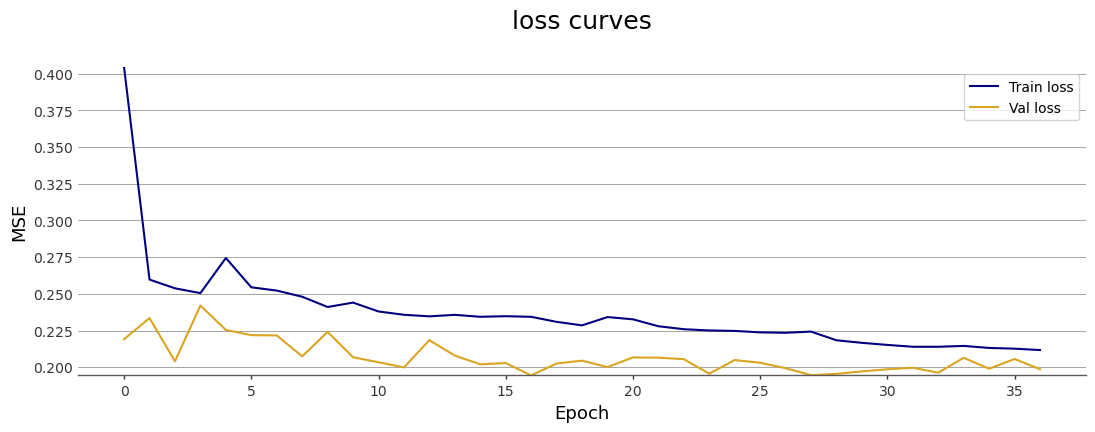

(8703, 24)
Overall forecast MAE : 0.1133
Overall forecast MSE: 0.3361
Overall forecast NSE: 0.7219
Overall forecast R^2: 0.7224
Overall forecast RSR: 0.5274
Overall forecast Pbias: -5.96%


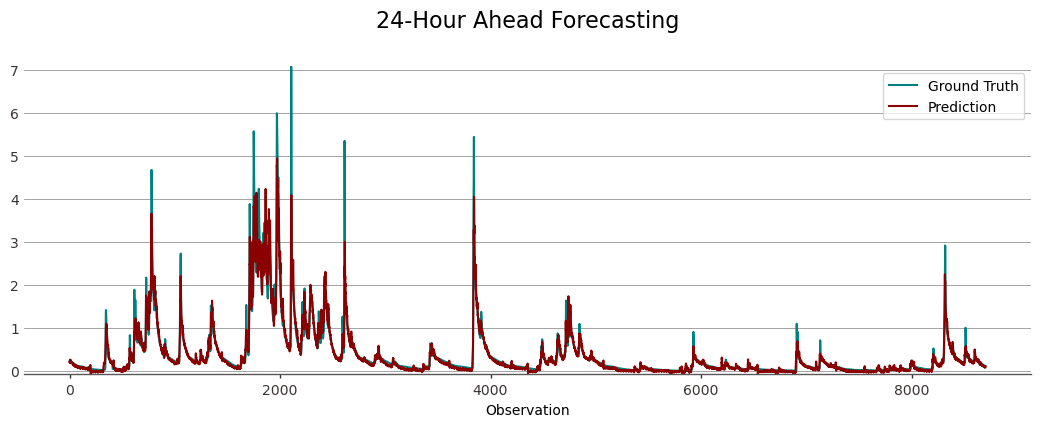

In [10]:
plt.title("loss curves", size=18, y=1.1)
plt.plot(all_losses, label=["Train loss", "Val loss"])
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("MSE", fontsize=13)
plt.legend(loc="upper right", fontsize=10)
plt.show()
model.load_state_dict(torch.load(model_save_path))

def predict(data_loader, model):
    pred, true = torch.tensor([]), torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.double()
            y = y.double()
            y_pred = model(X.float().to(device))
            pred=pred.to(device).double()
            true =true.to(device).double()
            pred = torch.cat((pred, y_pred.to(device)), 0).double()
            true = torch.cat((true, y.to(device)), 0).double()

    return pred, true
    
y_pred_tensor, y_test_tensor = predict(test_loader, model)
y_pred, y_test = y_pred_tensor.cpu().numpy(), y_test_tensor.cpu().numpy()
y_pred = y_pred.squeeze()
# Inverse the transformation
y_pred_inv1 = scaler_qrate.inverse_transform(y_pred)
y_test_inv1 = scaler_qrate.inverse_transform(y_test)
y_pred_inv = np.expm1(y_pred_inv1)
y_test_inv = np.expm1(y_test_inv1)

# Hours ahead to predict
forecast_length = 24

truth = y_test_inv[:, :] # 取所有时间步长的真实值
forecast = y_pred_inv[:, :]  # 取所有时间步长的预测值
print(truth.shape)
# 计算误差
diff = np.subtract(truth, forecast)

# 计算指标
mae = np.mean(np.abs(diff))  # MAE
mse = np.mean(np.square(diff))  # MSE
rmse = np.sqrt(mse)  # RMSE

# NSE
num = np.sum(np.square(diff))
den = np.sum(np.square(np.subtract(truth, truth.mean())))
nse = 1 - (num / den)

# R^2
numerator = np.square(np.sum((truth - truth.mean()) * (forecast - forecast.mean())))
denominator = np.sum(np.square(truth - truth.mean())) * np.sum(np.square(forecast - forecast.mean()))
r_squared = numerator / denominator

# RSR
rsr = rmse / np.std(truth)

# Pbias
pbias = np.mean(diff / truth) * 100

# 输出结果
print(f"Overall forecast MAE : {mae:.4f}")
print(f"Overall forecast MSE: {rmse:.4f}")
print(f"Overall forecast NSE: {nse:.4f}")
print(f"Overall forecast R^2: {r_squared:.4f}")
print(f"Overall forecast RSR: {rsr:.4f}")
print(f"Overall forecast Pbias: {pbias:.2f}%")

truth = y_test_inv[:, 0]
forecast = y_pred_inv[:, 0]

plt.title(f"{forecast_length}-Hour Ahead Forecasting", size=16, y=1.1)
plt.plot(truth, label="Ground Truth", color="teal")
plt.plot(forecast, label="Prediction", color="darkred")
plt.xlabel("Observation")
plt.legend(fontsize=10)
plt.show()